In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pytz import timezone
from datetime import datetime, timedelta, date
import json
import itertools
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score, make_scorer

# フォルダ移動
import os
os.chdir("/content/drive/MyDrive/projects/ICR - Identifying Age-Related Conditions/")

In [2]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")
df_sub = pd.read_csv("data/sample_submission.csv")
df_greeks = pd.read_csv("data/greeks.csv")

# FE
df_train["EJ"] = df_train["EJ"].replace({'A':0, 'B':1})
df_test["EJ"] = df_test["EJ"].replace({'A':0, 'B':1})

target = ["target"]
ex_columns = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'] # All
use_columns = ex_columns + target

display(df_train.head())
print(ex_columns)
print(len(ex_columns))

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,BN,BP,BQ,BR,BZ,CB,CC,CD,CF,CH,CL,CR,CS,CU,CW,DA,DE,DF,DH,DI,DL,DN,DU,DV,DY,EB,EE,EG,EH,EJ,EL,EP,EU,FC,FD,FE,FI,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,22.5984,175.638726,152.707705,823.928241,257.432377,47.223358,0.563481,23.387600,4.851915,0.023482,1.050225,0.069225,13.784111,1.302012,36.205956,69.08340,295.570575,0.23868,0.284232,89.245560,84.31664,29.657104,5.310690,1.74307,23.187704,7.294176,1.987283,1433.166750,0.949104,1,30.879420,78.526968,3.828384,13.394640,10.265073,9028.291921,3.583450,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,19.4205,155.868030,14.754720,51.216883,257.432377,30.284345,0.484710,50.628208,6.085041,0.031442,1.113875,1.117800,28.310953,1.357182,37.476568,70.79836,178.553100,0.23868,0.363489,110.581815,75.74548,37.532000,0.005518,1.74307,17.222328,4.926396,0.858603,1111.287150,0.003042,0,109.125159,95.415086,52.260480,17.175984,0.296850,6785.003474,10.358927,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,26.4825,128.988531,219.320160,482.141594,257.432377,32.563713,0.495852,85.955376,5.376488,0.036218,1.050225,0.700350,39.364743,1.009611,21.459644,70.81970,321.426625,0.23868,0.210441,120.056438,65.46984,28.053464,1.289739,1.74307,36.861352,7.813674,8.146651,1494.076488,0.377208,1,109.125159,78.526968,5.390628,224.207424,8.745201,8338.906181,11.626917,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,23.6577,237.282264,11.050410,661.518640,257.432377,15.201914,0.717882,88.159360,2.347652,0.029054,1.400300,0.636075,41.116960,0.722727,21.530392,47.27586,196.607985,0.23868,0.292431,139.824570,71.57120,24.354856,2.655345,1.74307,52.003884,7.386060,3.813326,15691.552180,0.614484,1,31.674357,78.526968,31.323372,59.301984,7.884336,10965.766040,14.852022,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,24.0108,324.546318,149.717165,6074.859475,257.432377,82.213495,0.536467,72.644264,30.537722,0.025472,1.050225,0.693150,31.724726,0.827550,34.415360,74.06532,200.178160,0.23868,0.207708,97.920120,52.83888,26.019912,1.144902,1.74307,9.064856,7.350720,3.490846,1403.656300,0.164268,1,109.125159,91.994825,51.141336,29.102640,4.274640,16198.049590,13.666727,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']
56


In [3]:
df_train.shape

(617, 58)

In [4]:
target = "Class"
random_state = 13
n_splits = 10
n_repeats = 10
num_boost_round = 1000
stopping_rounds = 50
learning_rate = 0.1
model_name = "LightGBM"

In [5]:
# コンペの評価指標
def balance_logloss(y_true, y_pred):
    y_pred = np.stack([1-y_pred, y_pred]).T
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    #y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    return logloss

metric = balance_logloss

In [6]:
# sklearnの関数に自作評価関数を入力したい場合は、make_scorerで変換をしたものが必要になる
# https://scikit-learn.org/stable/modules/model_evaluation.html#defining-your-scoring-strategy-from-metric-functions
scoring = make_scorer(metric)

In [7]:
# 探索したハイパラ
params = {'objective': 'binary', 'metric': 'binary_logloss', 'random_state': 13, 'verbose': -1, 'learning_rate': 0.1, 'max_depth': 6,
          'num_leaves': 130, 'min_data_in_leaf': 23, 'min_gain_to_split': 0.4770000759757845, 'max_bin': 456,
          'subsample': 0.7730309844043276, 'subsample_freq': 2, 'feature_fraction': 0.7135319817465602,
          'scale_pos_weight': 57.4385890562176}

FEATURES = df_train[ex_columns].columns.tolist()
df_importance = pd.DataFrame(index=FEATURES)
df_preds = df_sub[["Id"]].copy()
scores = []
pfi_scores = []

y = df_train[target]
X = df_train[ex_columns]
X_sub = df_test[ex_columns]
oof = np.zeros(len(y))
cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

for i, (train_index, val_index) in enumerate(cv.split(X, y)):
    print("=" * 20, f"START FOLD {i+1}", "=" * 20)
    y_train = y.iloc[train_index].to_numpy()
    X_train = X.iloc[train_index].to_numpy()
    y_val = y.iloc[val_index].to_numpy()
    X_val = X.iloc[val_index].to_numpy()

    data_train = lgb.Dataset(X_train, y_train)
    data_val = lgb.Dataset(X_val, y_val)
    evals_result = {}

    model = lgb.train(
        params,
        train_set=data_train,
        valid_sets=[data_train, data_val],
        num_boost_round=num_boost_round,
        #categorical_feature=cat_columns,
        callbacks=[
            lgb.early_stopping(stopping_rounds=stopping_rounds, verbose=True),
            lgb.record_evaluation(evals_result),
        ],
    )
    # 特徴量重要度
    df_importance[f"FOLD_{i+1}"] = model.feature_importance(importance_type="gain")
    # 検証データ
    y_pred = model.predict(X_val)
    score = metric(y_val, y_pred)
    scores.append(score)
    oof[val_index] += y_pred / n_repeats
    # 提出用データ
    pred = model.predict(X_sub)
    df_preds[f"pred_{i+1}"] = pred

    # PFIで重要度計算
    # (シャッフル前の精度 - シャッフル後の精度)が計算される、誤差系は重要な特徴量はマイナスに大きくなるはず
    # https://github.com/scikit-learn/scikit-learn/blob/7f9bad99d/sklearn/inspection/_permutation_importance.py#L101
    pfi = permutation_importance(
        estimator=model,
        X=X_val,
        y=y_val,
        scoring=scoring,
        n_repeats=5,
        n_jobs=-1,
        random_state=random_state)
    pfi_scores.append(pfi["importances_mean"].tolist())# 結果を入れる

==================== START FOLD 1 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0127094	valid_1's binary_logloss: 0.269505
==================== START FOLD 2 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0298523	valid_1's binary_logloss: 0.155846
==================== START FOLD 3 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00871894	valid_1's binary_logloss: 0.0591302
==================== START FOLD 4 ====================
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0124873	valid_1's binary_logloss: 0.111548
==================== START FOLD 5 ====================
Training until validation sc

<ipython-input-7-6cbbfb0ec40f>:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_preds[f"pred_{i+1}"] = pred


In [8]:
print(f"Score mean: {np.mean(scores)}, Fold scores: {scores}")

Score mean: 0.19769865368784567, Fold scores: [0.47178537908005186, 0.12302595509309466, 0.04319966800892261, 0.23233083799986365, 0.2894890916532623, 0.18520558183464997, 0.03419099547381641, 0.03834369332227508, 0.4487460686136461, 0.09708504610903518, 0.47146551851580737, 0.10813739524534809, 0.11487663405587975, 0.13785231950679436, 0.24268526601294288, 0.2656283518075087, 0.16837153949360925, 0.24947304359892417, 0.148485981086041, 0.0684509582087538, 0.1982814312286032, 0.1054346123296667, 0.1138677549383448, 0.1369350354923281, 0.18685922564710794, 0.13028163536787452, 0.4059744969074282, 0.20516878032035438, 0.29077641381422303, 0.2276373784571911, 0.48931780840127603, 0.18458606122763088, 0.17907980970630658, 0.06570505114402397, 0.18613342925779408, 0.21074496963788147, 0.13146244933597614, 0.07456012440862424, 0.37278621046277544, 0.14621325636421761, 0.18501190722193855, 0.18610182093838362, 0.13157528865215307, 0.3220678828701062, 0.4624644215038708, 0.1742556031623915, 0.

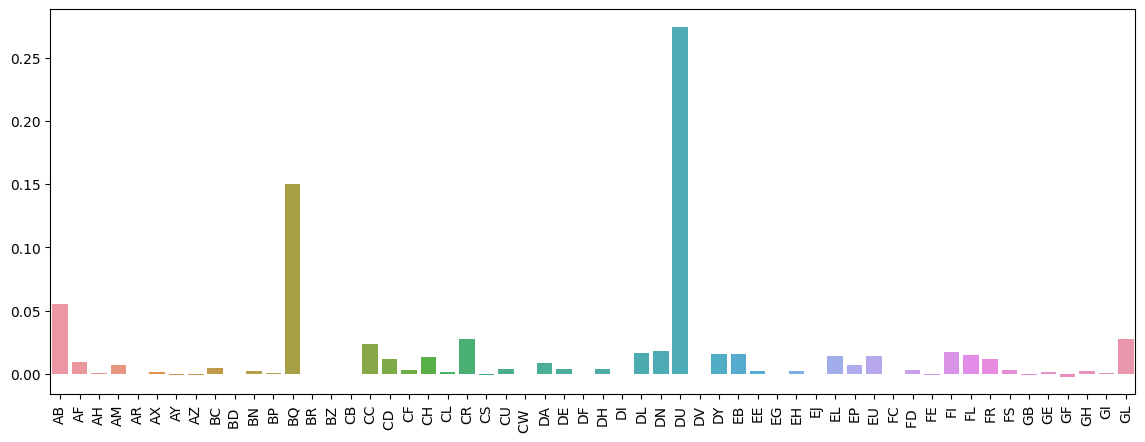

In [10]:
d = pd.DataFrame(pfi_scores, columns=FEATURES).mean()*-1
# (シャッフル後のlogloss - シャッフル前のlogloss)
fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x=d.index, y=d.to_numpy(), ax=ax)
plt.xticks(rotation=90)
plt.show()

In [12]:
d.sort_values(ascending=False).head(10)

DU    0.274526
BQ    0.150076
AB    0.055261
GL    0.027660
CR    0.027451
CC    0.023404
DN    0.018110
FI    0.017050
DL    0.016516
EB    0.015567
dtype: float64

In [13]:
d.sort_values(ascending=False).tail(10)

EG    -0.000199
DF    -0.000328
FC    -0.000346
CW    -0.000397
FE    -0.000619
CS    -0.000654
GB    -0.000703
AY    -0.000718
AZ    -0.000839
GF    -0.002432
dtype: float64